Imports

In [34]:
# from typing import Optional, Union

import numpy as np
# from numpy.typing import ArrayLike, NDArray
# from tabulate import tabulate
import matplotlib.pyplot as plt
# from scipy.stats import entropy


In [35]:
from reject.reject import ClassificationRejector
from reject.utils import generate_synthetic_output

In [36]:
from uncertainty_rejection.datasets import (
    load_mnist_data,
    # load_notmnist_data,
    # load_example_predictions
)
from uncertainty_rejection.analysis import (
    load_predictions,
    concat_get_idx,
)

In [37]:
from reject.reject import confusion_matrix, compute_metrics

(conf_matrix), _ = confusion_matrix(np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), 0.45, relative=True)
print(conf_matrix)
(metrics) = compute_metrics(0.45, np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), relative=True)

(1, 2, 1, 1)
             Non-rejected    Rejected
---------  --------------  ----------
Correct                 2           1
Incorrect               1           1

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.6667                    0.6000               1.5000


In [62]:
assert isinstance(metrics, tuple)
assert isinstance(metrics[0], tuple)
assert isinstance(metrics[1], np.ndarray)

In [38]:
(conf_matrix), _ = confusion_matrix(np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), 0.1, relative=True)
print(conf_matrix)
(metrics) = compute_metrics(0.1, np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), relative=True)

(0, 3, 0, 2)
             Non-rejected    Rejected
---------  --------------  ----------
Correct                 3           0
Incorrect               2           0

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.6000                    0.6000               1.0000


In [39]:
(conf_matrix), _ = confusion_matrix(np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), 0.9, relative=True)
print(conf_matrix)
(metrics) = compute_metrics(0.9, np.array([1., 0., 1., 1., 0.]), np.array([0.2, 0.8, 0.4, 0.6, 0.5]), relative=True)

(2, 1, 2, 0)
             Non-rejected    Rejected
---------  --------------  ----------
Correct                 1           2
Incorrect               0           2

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 1.0000                    0.6000               1.5000


Get real data

In [40]:
# load MNIST data (do not need train data or test features)
(_, _), (_, y_mnist) = load_mnist_data()

In [41]:
# load Not-MNIST data (do not need features)
with np.load("../not_mnist.npz", allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

    notmnist= (x_train, y_train), (x_test, y_test)
(_, _), (_, y_notmnist) = notmnist

# give not-MNIST observation a different label -> should be incorrect
y_notmnist.fill(999)

In [42]:
# load predictions
y_stack_all, y_mean_all, y_label_all = load_predictions("../example_preds_mnist_notmnist.npy")
NUM_CLASSES = y_stack_all.shape[-1]

y_stack shape: 	(28724, 128, 10)
y_mean shape: 	(28724, 10)
y_label shape: 	(28724,)


In [43]:
y_true_all, idlist, idx_mnist, idx_notmnist, *_ = concat_get_idx(y_mnist, y_notmnist)

Generate synthetic data

In [44]:
# TODO: vector correct/wrong and order and uncertainty
num_ood_obs = 5000
num_id_obs = 5000
id_accuracy = 0.95
shuffle_rate = 0.1 # TODO


In [45]:
num_id_correct = int(num_id_obs * id_accuracy)
num_id_wrong = num_id_obs - num_id_correct

In [46]:
y_pred_correct = np.concatenate(
    (np.zeros((num_ood_obs)), np.zeros((num_id_wrong)), np.ones((num_id_correct)))
)

y_pred_uncertainty = np.concatenate(
    (
        np.random.normal(2.5, 0.5, num_ood_obs),
        np.random.normal(1.5, 0.5, num_id_wrong),
        np.random.normal(0.1, 0.1, num_id_correct),
    )
)
# make negative values 0
y_pred_uncertainty = np.maximum(y_pred_uncertainty, 0)

np.random.seed(seed=44)
random_draws = np.random.random(y_pred_uncertainty.size)
y_reject_order = np.lexsort((random_draws, y_pred_uncertainty))
y_reject_order = np.flip(y_reject_order, axis=0)

y_pred_confidence = y_pred_uncertainty / np.max(y_pred_uncertainty)
y_pred_confidence = np.flip(y_pred_confidence, axis=0)

y_pred_tu = y_pred_uncertainty
y_pred_au = y_pred_uncertainty / 2
y_pred_eu = y_pred_uncertainty / 2
uncertainty_dict = {"TU": y_pred_tu, "AU": y_pred_au, "EU": y_pred_eu}


Synthetic output data

In [47]:
NUM_SAMPLES = 10
NUM_OBSERVATIONS = 1000
NUM_CLASSES = 10

y_pred_all, y_true_all = generate_synthetic_output(NUM_SAMPLES, NUM_OBSERVATIONS)

ClassificationRejection

In [48]:
rej = ClassificationRejector(y_true_all, y_pred_all)

In [49]:
# fig, ax = plt.subplots()
# counts, edges = np.histogram(ClassificationRejector(y_true_ood, y_pred_ood).uncertainty("TU"), bins=15)
# ax.stairs(counts, edges, fill=True)

In [50]:
# fig, ax = plt.subplots()
# counts, edges = np.histogram(ClassificationRejector(y_true_id, y_pred_id).uncertainty("TU"), bins=15)
# ax.stairs(counts, edges, fill=True)

In [51]:
# fig, ax = plt.subplots()
# counts, edges = np.histogram(ClassificationRejector(y_true_ood, y_pred_ood).uncertainty("confidence"), bins=15)
# ax.stairs(counts, edges, fill=True)

In [52]:
# fig, ax = plt.subplots()
# counts, edges = np.histogram(ClassificationRejector(y_true_id, y_pred_id).uncertainty("confidence"), bins=15)
# ax.stairs(counts, edges, fill=True)

In [53]:
# implement single rejection point
rej.reject(threshold=0.5, unc_type="TU", relative=True, show=True)

             Non-rejected    Rejected
---------  --------------  ----------
Correct               893          21
Incorrect             107         979

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.8930                    0.9360              39.2356


((0.893, 0.936, 39.23555204770674),
 array([ True,  True,  True, ..., False, False, False]))

Figure(450x300)
Figure(450x300)


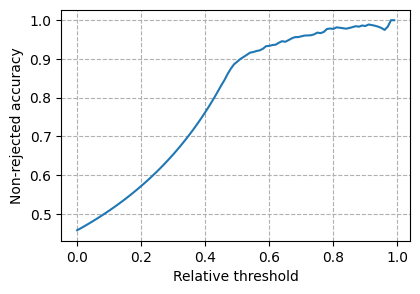

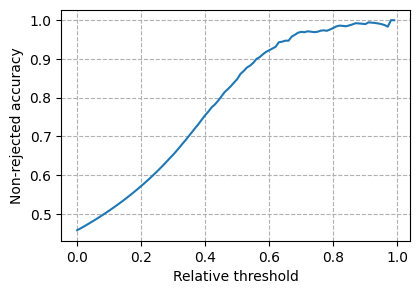

In [57]:
fig = rej.plot_reject(unc_type="TU", metric="NRA")
print(fig)
fig = rej.plot_reject(unc_type="confidence", metric="NRA")
print(fig)

Figure(450x300)
Figure(450x300)


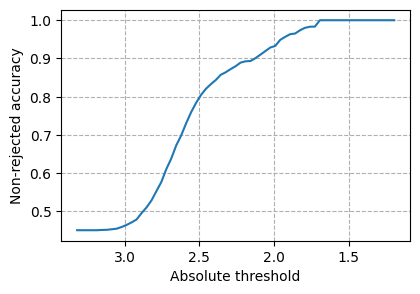

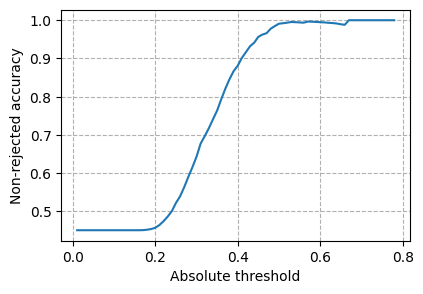

In [301]:
fig = rej.plot(unc_type="TU", metric="NRA", relative=False)
print(fig)
fig = rej.plot(unc_type="confidence", metric="NRA", relative=False)
print(fig)

Utils

In [7]:
# print(confusion_matrix_rej(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     threshold=0.5,
#     relative=True,
#     show=True,
#     seed=44,
# ))

# print(confusion_matrix_rej(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     threshold=2.0,
#     relative=False,
#     show=True,
#     seed=44,
# ))

             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect             250        5000
(0, 4750, 5000, 250)
             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect            1074        4176
(0, 4750, 4176, 1074)


In [8]:

# print(compute_metrics_rej(
#     threshold=0.5,
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     relative=True,
#     show=True,
#     seed=44,
# ))

# print(compute_metrics_rej(
#     threshold=2.0,
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     relative=False,
#     show=True,
#     seed=44,
# ))

             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect             250        5000

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.9500                    0.9750                  inf
(0.95, 0.975, inf)
             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect            1074        4176

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.8156                    0.8926                  inf
(0.8155906593406593, 0.8926, inf)


In [9]:
# class NonRejectedAccuracy:
#     def __init__(
#         self,
#         relative: bool = True,
#         seed: int = 44,
#     ):
#         self.relative = relative
#         self.seed = seed

#     def __call__(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         threshold: float,
#     ):
#         _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
#             correct=correct,
#             unc_ary=unc_ary,
#             threshold=threshold,
#             show=False,
#             relative=self.relative,
#             seed=self.seed,
#         )
#         try:
#             nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
#         except ZeroDivisionError:
#             nonrej_acc = np.inf  # invalid
#         return nonrej_acc


# nra = NonRejectedAccuracy(relative=True, seed=44)
# print(nra(correct=y_pred_correct, unc_ary=y_pred_uncertainty, threshold=0.4))

In [10]:
# def non_rejected_accuracy(
#     correct: ArrayLike,
#     unc_ary: ArrayLike,
#     threshold: float,
#     relative: bool = True,
#     seed: int = 44,
# ) -> float:
#     """Compute non-rejected accuracy (NRA).

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
#     threshold : float
#         Rejection threshold.
#     relative : bool, optional
#         Use relative rejection, otherwise absolute rejection.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44

#     Returns
#     -------
#     float
#         Value of non-rejected accuracy.
#     """
#     _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
#         correct=correct,
#         unc_ary=unc_ary,
#         threshold=threshold,
#         show=False,
#         relative=relative,
#         seed=seed,
#     )
#     try:
#         nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
#     except ZeroDivisionError:
#         nonrej_acc = np.inf  # invalid
#     return nonrej_acc


# def classification_quality(
#     correct: ArrayLike,
#     unc_ary: ArrayLike,
#     threshold: float,
#     relative: bool = True,
#     seed: int = 44,
# ) -> float:
#     """Compute classification quality (CQ).

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
#     threshold : float
#         Rejection threshold.
#     relative : bool, optional
#         Use relative rejection, otherwise absolute rejection.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44

#     Returns
#     -------
#     float
#         Value of classification quality.
#     """
#     n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
#         correct=correct,
#         unc_ary=unc_ary,
#         threshold=threshold,
#         show=False,
#         relative=relative,
#         seed=seed,
#     )
#     try:
#         class_quality = (n_cor_nonrej + n_incor_rej) / (
#             n_cor_rej + n_cor_nonrej + n_incor_rej + n_incor_nonrej
#         )
#     except ZeroDivisionError:
#         class_quality = np.inf  # invalid
#     return class_quality


# def rejection_quality(
#     correct: ArrayLike,
#     unc_ary: ArrayLike,
#     threshold: float,
#     relative: bool = True,
#     seed: int = 44,
# ) -> float:
#     """Compute rejection quality (CQ).

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
#     threshold : float
#         Rejection threshold.
#     relative : bool, optional
#         Use relative rejection, otherwise absolute rejection.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44

#     Returns
#     -------
#     float
#         Value of rejection quality.
#     """
#     n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
#         correct=correct,
#         unc_ary=unc_ary,
#         threshold=threshold,
#         show=False,
#         relative=relative,
#         seed=seed,
#     )
#     try:
#         rej_quality = (n_incor_rej / n_cor_rej) / (
#             (n_incor_rej + n_incor_nonrej) / (n_cor_rej + n_cor_nonrej)
#         )
#     except ZeroDivisionError:
#         if (n_incor_rej + n_cor_rej) > 0:
#             rej_quality = np.inf
#         else:
#             rej_quality = 1.0
#     return rej_quality


# print(
#     non_rejected_accuracy(correct=y_pred_correct, unc_ary=y_pred_uncertainty, threshold=0.4)
# )

0.7916666666666666


RejectionPlot

In [57]:
# class RejectionPlot:
#     def __init__(
#         self,
#         relative: bool = True,
#         seed: int = 44,
#         space_start: float = 0.001,
#         space_stop: float = 0.99,
#         space_bins: int = 100,
#         num_labels: Optional[int] = None,
#     ):
#         self.relative = relative
#         self.seed = seed
#         self.space_start = space_start
#         self.space_stop = space_stop
#         self.space_bins = space_bins
#         self.num_labels = num_labels

#     def plot(
#         self,
#         y_true: ArrayLike,
#         y_pred: ArrayLike,
#         unc_type: Optional[str] = None,
#         metric: Optional[str] = None,
#         fig: Optional[plt.Figure] = None,
#         filename: Optional[str] = None,
#         **save_args
#     ) -> plt.Figure:
#         if unc_type is None and metric is None:
#             raise ValueError("`unc_type` and `metric` cannot be both None, at least one must be specified.")
            
#         # get uncertainty and correctness
#         unc_ary = compute_uncertainty(y_pred, unc_type=unc_type)
#         correct = compute_correct(y_true, y_pred)

#         if isinstance(unc_type, str) and metric is not None:
#             fig = self.__plot_1_panel(
#                 correct=correct,
#                 unc_ary=unc_ary if isinstance(unc_ary,(list, np.ndarray)) else unc_ary[unc_type], # TODO: check if this works
#                 metric=metric,
#                 unc_type=unc_type,
#                 fig=fig,
#                 filename=filename,
#                 **save_args
#             )
#         elif metric is None:
#             fig = self.__plot_3_metric_panels(
#                 correct=correct,
#                 unc_ary=unc_ary if isinstance(unc_ary,(list, np.ndarray)) else unc_ary[unc_type], # TODO: check if this works,
#                 unc_type=unc_type,
#                 fig=fig,
#                 filename=filename,
#                 **save_args
#             )
#         # TODO: handle case where uncertainty type is None
#         elif unc_type is None:
#             fig = self.__plot_3_uncertainty_panels(
#                 correct=correct,
#                 unc_ary=unc_ary,
#                 metric=metric,
#                 fig=fig,
#                 filename=filename,
#                 **save_args
#             )
#         return fig

#     def __plot_1_panel(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         metric: str,
#         unc_type: str,
#         fig: Optional[plt.Figure] = None,
#         filename: Optional[str] = None,
#         **save_args
#     ) -> plt.Figure:
#         unc_types = ["TU", "AU", "EU", "confidence"]
#         if unc_type not in unc_types:
#             raise ValueError(
#                 "Invalid uncertainty type. Expected one of: %s" % unc_types
#             )
#         unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
#         if (
#             unc_type == "confidence"
#         ):  # TODO: find other way, e.g. flip uncertainty vector
#             # largest value is most uncertain
#             unc_ary = 1.0 - unc_ary

#         # draw routines
#         if fig is None:
#             fig, ax = plt.subplots()
#         # use an existing figure object if given
#         else:
#             ax = fig.add_subplot(1, 1, 1)

#         self.__plot_base_panel(
#             correct=correct,
#             unc_ary=unc_ary,
#             metric=metric,
#             unc_type=unc_type,
#             ax=ax,
#         )
#         ax.grid(linestyle="dashed")
#         if self.relative:
#             ax.set(xlabel="Relative threshold", ylabel="Metric")
#         else:
#             ax.set(xlabel="Absolute threshold", ylabel="Metric")
#         if filename is not None:
#             fig.tight_layout()
#             fig.savefig(filename, **save_args)
#         return fig

#     def __plot_3_metric_panels(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         unc_type: str,
#         fig: Optional[plt.Figure] = None,
#         filename: Optional[str] = None,
#         **save_args
#     ) -> plt.Figure:
#         unc_types = ["TU", "AU", "EU", "confidence"]
#         if unc_type not in unc_types:
#             raise ValueError(
#                 "Invalid uncertainty type. Expected one of: %s" % unc_types  # TODO: is this needed?
#             )
#         unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
#         if unc_type == "confidence":
#             # largest value is most uncertain
#             unc_ary = 1.0 - unc_ary

#         label_dict = {
#             "NRA": "Non-rejected accuracy",
#             "CQ": "Classification quality",
#             "RQ": "Rejection quality",
#         }
#         # draw routines
#         if fig is None:
#             fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
#         # use an existing figure object if given
#         else:
#             axes = [
#                 fig.add_subplot(3, 1, 1),
#                 fig.add_subplot(3, 1, 2),
#                 fig.add_subplot(3, 1, 3),
#             ]
#         for i, label in enumerate(label_dict.keys()):
#             self.__plot_base_panel(
#                 correct=correct,
#                 unc_ary=unc_ary,
#                 metric=label,
#                 unc_type=unc_type,
#                 ax=axes[i],
#             )
#             axes[i].grid(linestyle="dashed")
#             if self.relative:
#                 axes[i].set(xlabel="Relative threshold", ylabel=label_dict[label])
#             else:
#                 axes[i].set(xlabel="Absolute threshold", ylabel=label_dict[label])

#         if filename is not None:
#             fig.tight_layout()
#             fig.savefig(filename, **save_args)
#         return fig

#     def __plot_3_uncertainty_panels(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         metric: str,
#         fig: Optional[plt.Figure] = None,
#         filename: Optional[str] = None,
#         **save_args
#     ) -> plt.Figure:
        
#         label_dict = {
#             "NRA": "Non-rejected accuracy",
#             "CQ": "Classification quality",
#             "RQ": "Rejection quality",
#         }
#         # unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
#         # draw routines
#         if fig is None:
#             fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
#         # use an existing figure object if given
#         else:
#             axes = [
#                 fig.add_subplot(3, 1, 1),
#                 fig.add_subplot(3, 1, 2),
#                 fig.add_subplot(3, 1, 3),
#             ]
#         for i, unc_type in enumerate(["TU", "AU", "EU"]):
#             self.__plot_base_panel(
#                 correct=correct,
#                 unc_ary=unc_ary[unc_type],
#                 metric=metric,
#                 unc_type="entropy",
#                 ax=axes[i],
#             )
#             axes[i].grid(linestyle="dashed")
#             if self.relative:
#                 axes[i].set(xlabel="Relative threshold", ylabel=label_dict[metric])
#             else:
#                 axes[i].set(xlabel="Absolute threshold", ylabel=label_dict[metric])

#         if filename is not None:
#             fig.tight_layout()
#             fig.savefig(filename, **save_args)
#         return fig

#     def __plot_base_panel(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         metric: str,
#         unc_type: str,
#         ax: Optional[plt.Axes] = None,
#     ) -> plt.Axes:
#         unc_types = ["entropy", "confidence"]
#         if unc_type not in unc_types:
#             raise ValueError(
#                 "Invalid uncertainty type. Expected one of: %s" % unc_types
#             )
#         if self.relative:
#             treshold_ary = np.linspace(
#                 start=self.space_start, stop=self.space_stop, num=self.space_bins
#             )
#             reject_ary = treshold_ary
#             plot_ary = treshold_ary
#         elif not self.relative and unc_type == "confidence":
#             treshold_ary = np.linspace(
#                 start=(1 - self.space_start),
#                 stop=(1 - self.space_stop),
#                 num=self.space_bins,
#             )
#             reject_ary = treshold_ary
#             plot_ary = np.flip(treshold_ary, axis=0)
#         elif not self.relative and unc_type == "entropy":
#             if self.num_labels is not None:
#                 max_entropy = np.log2(self.num_labels)
#             else:
#                 max_entropy = np.max(unc_ary)
#             treshold_ary = np.linspace(
#                 start=(1 - self.space_start) * max_entropy,
#                 stop=(1 - self.space_stop) * max_entropy,
#                 num=self.space_bins,
#             )
#             reject_ary = treshold_ary
#             plot_ary = treshold_ary

#         compute_metrics_rej_v = np.vectorize(
#             compute_metrics_rej,
#             excluded=["correct", "unc_ary", "show", "relative", "seed"],
#         )
#         nonrej_acc, class_quality, rej_quality = compute_metrics_rej_v(
#             reject_ary,
#             correct=correct,
#             unc_ary=unc_ary,
#             show=False,
#             relative=self.relative,
#             seed=self.seed,
#         )

#         # plot on existing axis or new axis
#         if ax is None:
#             ax = plt.gca()
#         if metric == "NRA":
#             ax.plot(plot_ary, nonrej_acc)
#         elif metric == "CQ":
#             ax.plot(plot_ary, class_quality)
#         elif metric == "RQ":
#             ax.plot(plot_ary, rej_quality)

#         if not self.relative and unc_type == "entropy":
#             # invert x-axis, largest uncertainty values on the left
#             ax.invert_xaxis()
#         return ax

# # # test __plot_1_panel, absolute threshold, total uncertainty
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_uncertainty,
# #     metric="NRA",
# #     unc_type="TU",
# # )
# # # test __plot_1_panel, relative threshold, total uncertainty
# # fig = RejectionPlot(relative=True, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_uncertainty,
# #     metric="NRA",
# #     unc_type="TU",
# # )

# # # test __plot_3_metric_panels, absolute threshold, total uncertainty
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_uncertainty,
# #     metric=None,
# #     unc_type="TU",
# # )
# # # test __plot_3_metric_panels, relative threshold, total uncertainty
# # fig = RejectionPlot(relative=True, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_uncertainty,
# #     metric=None,
# #     unc_type="TU",
# # )
    
# # # test __plot_1_panel, absolute threshold, confidence
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_confidence,
# #     metric="NRA",
# #     unc_type="confidence",
# # )
# # # test __plot_1_panel, relative threshold, confidence
# # fig = RejectionPlot(relative=True, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_confidence,
# #     metric="NRA",
# #     unc_type="confidence",
# # )

# # # test __plot_3_metric_panels, absolute threshold, confidence
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_confidence,
# #     metric=None,
# #     unc_type="confidence",
# # )
# # # test __plot_3_metric_panels, relative threshold, confidence
# # fig = RejectionPlot(relative=True, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_confidence,
# #     metric=None,
# #     unc_type="confidence",
# # )
    
# # # test __plot_1_panel, absolute threshold, uncertainty dict
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=uncertainty_dict,
# #     metric="NRA",
# #     unc_type="TU",
# # )

# # # test __plot_3_uncertainty_panel, absolute threshold, uncertainty dict
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=uncertainty_dict,
# #     metric="NRA",
# #     unc_type=None,
# # )

# # # test __plot_3_metric_panel, absolute threshold, uncertainty dict
# # fig = RejectionPlot(relative=False, num_labels=10).plot(
# #     correct=y_pred_correct,
# #     unc_ary=uncertainty_dict,
# #     metric=None,
# #     unc_type="TU",
# # )




Uncertainty

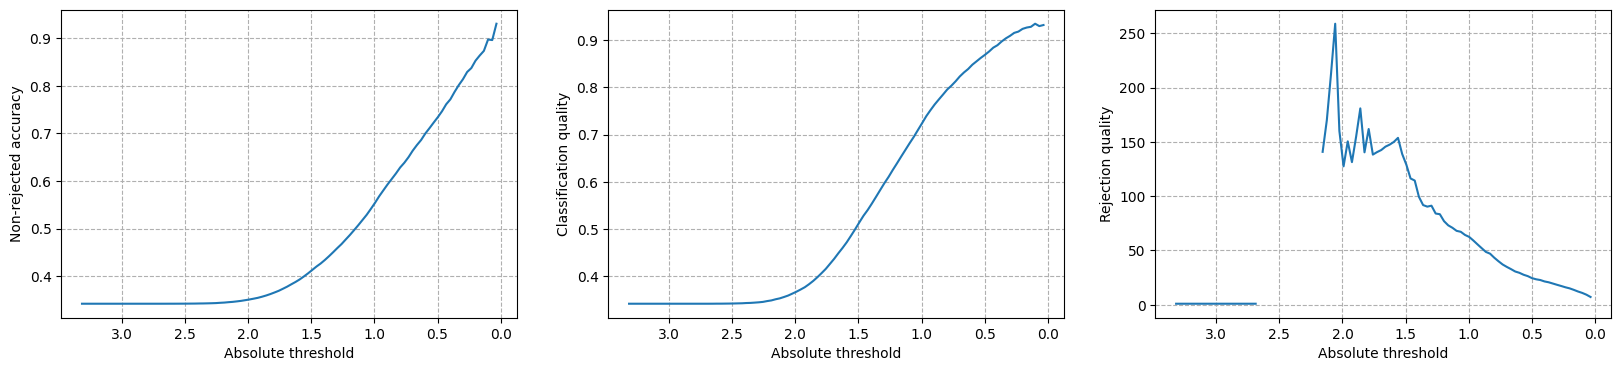

In [58]:
# # test
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     y_true=y_true_all,
#     y_pred=y_stack_all,
#     metric=None,
#     unc_type="TU", # TODO: fix that it is only typed once (was done in uncertainty)
# )